In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
# ================== CONFIGURAÇÃO ==================
IMAGE_SIZE = (128, 128)  # Tamanho das imagens
BATCH_SIZE = 128
NUM_CLASSES = 8  # Altere para número de suas classes
EPOCHS = 300

#preparo de dados

def load_images_from_folder(folder_path):
    images = []
    labels = []

    #verificar se pasta existe
    if not os.path.exists(folder_path):
        print(f"ERRO: Pasta '{folder_path}' não encontrada!")
        print("Crie a pasta com esta estrutura:")
        print("pasta de teste/")
        print("├── classe1/")
        print("│   ├── img1.jpg")
        print("│   └── img2.jpg")
        print("├── classe2/")
        print("│   ├── img1.jpg")
        print("│   └── img2.jpg")
        print("└── classe3/")
        return np.array([]), np.array([]), []
    
    class_names = sorted([d for d in os.listdir(folder_path) 
                         if os.path.isdir(os.path.join(folder_path, d))])
    
    if not class_names:
        print(f"ERRO: Nenhuma subpasta encontrada em '{folder_path}'")
        return np.array([]), np.array([]), []
    
    print(f"Encontradas {len(class_names)} classes: {class_names}")
    
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        image_count = 0
        
        for image_file in os.listdir(class_path):
            if image_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_path = os.path.join(class_path, image_file)
                try:
                    img = Image.open(image_path).convert('RGB')
                    img = img.resize(IMAGE_SIZE)
                    img_array = np.array(img) / 255.0  # Normalizar [0, 1]
                    images.append(img_array)
                    labels.append(class_idx)
                    image_count += 1
                except Exception as e:
                    print(f"Erro ao carregar {image_path}: {e}")
        
        print(f"Classe '{class_name}': {image_count} imagens")
    
    return np.array(images), np.array(labels), class_names

In [3]:
# ================== DIAGNÓSTICO DOS DADOS ==================
def diagnosticar_dados(X, y, class_names):
    print("\n" + "="*50)
    print("DIAGNÓSTICO COMPLETO DOS DADOS")
    print("="*50)
    
    if len(X) == 0:
        print("❌ NENHUMA IMAGEM CARREGADA!")
        return False
    
    print(f"✅ Total de imagens: {len(X)}")
    print(f"✅ Número de classes: {len(class_names)}")
    print(f"✅ Formato das imagens: {X[0].shape}")
    
    # Distribuição de classes
    print("\n📊 DISTRIBUIÇÃO DAS CLASSES:")
    for i, class_name in enumerate(class_names):
        count = np.sum(y == i)
        porcentagem = count / len(y) * 100
        print(f"   {class_name}: {count} imagens ({porcentagem:.1f}%)")
    
    # Verificar balanceamento
    counts = [np.sum(y == i) for i in range(len(class_names))]
    min_count = min(counts)
    max_count = max(counts)
    
    if min_count == 0:
        print("❌ ALERTA: Alguma classe não tem nenhuma imagem!")
        return False
    
    if max_count / min_count > 3:
        print("⚠️  ALERTA: Classes desbalanceadas (mais de 3x diferença)")
    else:
        print("✅ Classes relativamente balanceadas")
    
    # Verificar normalização
    print(f"\n🔍 VALORES DOS PIXELS:")
    print(f"   Mínimo: {X.min():.3f} (deve ser próximo de 0)")
    print(f"   Máximo: {X.max():.3f} (deve ser próximo de 1)")
    print(f"   Média: {X.mean():.3f}")
    
    if X.min() < 0 or X.max() > 1:
        print("❌ ERRO: Imagens não estão normalizadas entre 0 e 1!")
        return False
    else:
        print("✅ Imagens corretamente normalizadas")
    
    # # Mostrar exemplo de imagens
    # print(f"\n👀 EXEMPLO DE IMAGENS (primeiras 3):")
    # plt.figure(figsize=(12, 4))
    # for i in range(min(3, len(X))):
    #     plt.subplot(1, 3, i+1)
    #     plt.imshow(X[i])
    #     plt.title(f'Classe: {class_names[y[i]]}\nShape: {X[i].shape}')
    #     plt.axis('off')
    # plt.tight_layout()
    # plt.show()
    
    return True

In [4]:
# ================== PLOTAR GRÁFICOS ==================
def plot_training_history(history, hidden_units):
    plt.figure(figsize=(15, 5))
    
    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title(f'Training and Validation Accuracy\n({hidden_units} units)', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Gráfico de Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title(f'Training and Validation Loss\n({hidden_units} units)', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [5]:
def create_img_cnn(input_shape, num_class, hidden_units=128):
    model = Sequential([
        # Bloco 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # layers.Dropout(0.25),
        
        # Bloco 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu',  padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # layers.Dropout(0.25),
        
        # Bloco 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu',  padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # layers.Dropout(0.25),

        # # Bloco 4
        # layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        # layers.BatchNormalization(),
        # layers.Conv2D(256, (3, 3), activation='relu',  padding='same'),
        # layers.BatchNormalization(),
        # layers.MaxPooling2D((2, 2)),
        # layers.Dropout(0.25),
        
        layers.Flatten(),
        
        # Dense layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # layers.Dense(256, activation='relu'),
        # layers.BatchNormalization(),
        # layers.Dropout(0.5),

        layers.Dense(num_class, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Carregando imagens...
Encontradas 8 classes: ['borda_4,22', 'borda_4,88', 'borda_5,63', 'borda_6,65', 'centro_4,22', 'centro_4,88', 'centro_5,63', 'centro_6,65']
Classe 'borda_4,22': 800 imagens
Classe 'borda_4,88': 800 imagens
Classe 'borda_5,63': 800 imagens
Classe 'borda_6,65': 810 imagens
Classe 'centro_4,22': 800 imagens
Classe 'centro_4,88': 810 imagens
Classe 'centro_5,63': 800 imagens
Classe 'centro_6,65': 800 imagens

DIAGNÓSTICO COMPLETO DOS DADOS
✅ Total de imagens: 6420
✅ Número de classes: 8
✅ Formato das imagens: (128, 128, 3)

📊 DISTRIBUIÇÃO DAS CLASSES:
   borda_4,22: 800 imagens (12.5%)
   borda_4,88: 800 imagens (12.5%)
   borda_5,63: 800 imagens (12.5%)
   borda_6,65: 810 imagens (12.6%)
   centro_4,22: 800 imagens (12.5%)
   centro_4,88: 810 imagens (12.6%)
   centro_5,63: 800 imagens (12.5%)
   centro_6,65: 800 imagens (12.5%)
✅ Classes relativamente balanceadas

🔍 VALORES DOS PIXELS:
   Mínimo: 0.000 (deve ser próximo de 0)
   Máximo: 1.000 (deve ser próximo de 1)

c:\Users\chena\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



📋 Summary do modelo (32 unidades):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,072,680 (65.13 MB)

 Trainable params: 17,070,760 (65.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

c:\Users\chena\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2867 - loss: 2.4768

30/30 ━━━━━━━━━━━━━━━━━━━━ 251s 8s/step - accuracy: 0.3561 - loss: 1.9810 - val_accuracy: 0.1246 - val_loss: 6.3210 - learning_rate: 0.0010
Epoch 2/300
 1/30 ━━━━━━━━━━━━━━━━━━━━ 3:41 8s/step - accuracy: 0.4688 - loss: 1.5171

c:\Users\chena\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 721ms/step - accuracy: 0.4688 - loss: 1.5171 - val_accuracy: 0.1246 - val_loss: 6.1022 - learning_rate: 0.0010
Epoch 3/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 225s 7s/step - accuracy: 0.5666 - loss: 1.1869 - val_accuracy: 0.1246 - val_loss: 6.2137 - learning_rate: 0.0010
Epoch 4/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 493ms/step - accuracy: 0.5938 - loss: 1.1182 - val_accuracy: 0.1246 - val_loss: 6.3654 - learning_rate: 0.0010
Epoch 5/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6075 - loss: 1.1029

30/30 ━━━━━━━━━━━━━━━━━━━━ 220s 7s/step - accuracy: 0.6230 - loss: 1.0612 - val_accuracy: 0.1254 - val_loss: 8.6726 - learning_rate: 0.0010
Epoch 6/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 713ms/step - accuracy: 0.6016 - loss: 1.1579 - val_accuracy: 0.1199 - val_loss: 8.7254 - learning_rate: 0.0010
Epoch 7/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 229s 8s/step - accuracy: 0.7021 - loss: 0.8432 - val_accuracy: 0.1246 - val_loss: 12.7061 - learning_rate: 0.0010
Epoch 8/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 488ms/step - accuracy: 0.6667 - loss: 0.6582 - val_accuracy: 0.1246 - val_loss: 11.5831 - learning_rate: 2.5000e-04
Epoch 9/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7419 - loss: 0.6975

30/30 ━━━━━━━━━━━━━━━━━━━━ 222s 7s/step - accuracy: 0.7462 - loss: 0.6967 - val_accuracy: 0.1355 - val_loss: 6.8494 - learning_rate: 2.5000e-04
Epoch 10/300
 1/30 ━━━━━━━━━━━━━━━━━━━━ 3:21 7s/step - accuracy: 0.7656 - loss: 0.5906

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 502ms/step - accuracy: 0.7656 - loss: 0.5906 - val_accuracy: 0.1402 - val_loss: 6.9545 - learning_rate: 2.5000e-04
Epoch 11/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 221s 7s/step - accuracy: 0.7696 - loss: 0.6372 - val_accuracy: 0.1394 - val_loss: 7.0505 - learning_rate: 2.5000e-04
Epoch 12/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 487ms/step - accuracy: 0.7500 - loss: 0.6319 - val_accuracy: 0.1394 - val_loss: 6.9971 - learning_rate: 2.5000e-04
Epoch 13/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 225s 8s/step - accuracy: 0.7838 - loss: 0.5983 - val_accuracy: 0.0958 - val_loss: 7.3999 - learning_rate: 6.2500e-05
Epoch 14/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 711ms/step - accuracy: 0.7734 - loss: 0.5605 - val_accuracy: 0.1012 - val_loss: 7.4029 - learning_rate: 6.2500e-05
Epoch 15/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 219s 7s/step - accuracy: 0.7970 - loss: 0.5577 - val_accuracy: 0.1036 - val_loss: 7.6456 - learning_rate: 6.2500e-05
Epoch 16/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 486ms/step - accuracy

30/30 ━━━━━━━━━━━━━━━━━━━━ 224s 7s/step - accuracy: 0.8136 - loss: 0.5202 - val_accuracy: 0.1511 - val_loss: 6.6151 - learning_rate: 1.5625e-05
Epoch 22/300
 1/30 ━━━━━━━━━━━━━━━━━━━━ 3:43 8s/step - accuracy: 0.8203 - loss: 0.4645

30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 540ms/step - accuracy: 0.8203 - loss: 0.4645 - val_accuracy: 0.1526 - val_loss: 6.5919 - learning_rate: 1.5625e-05


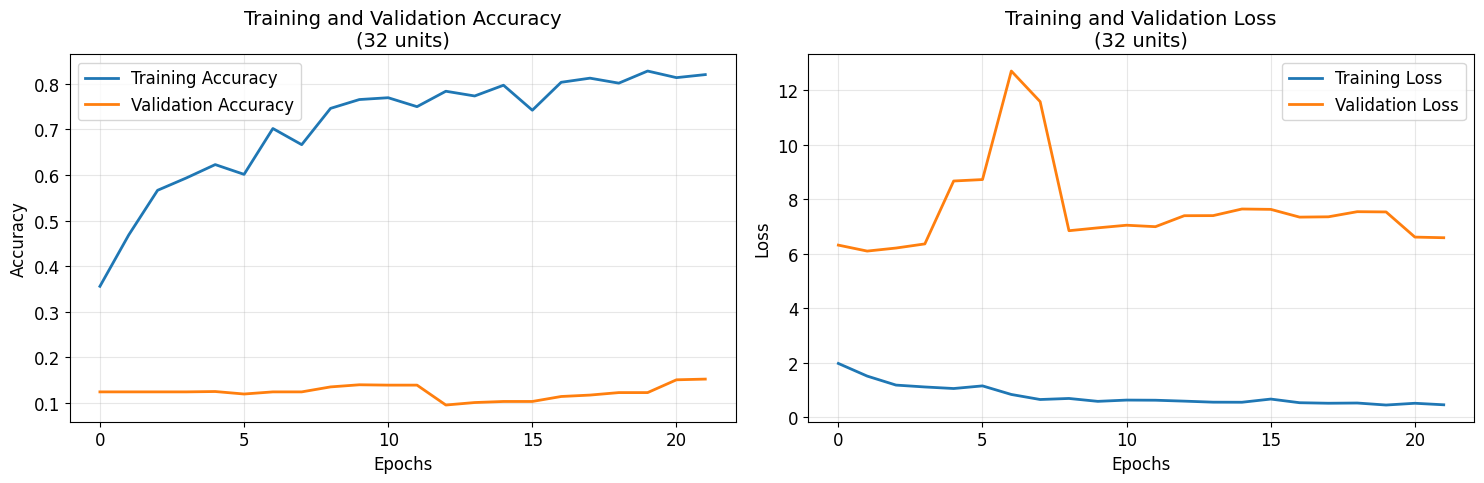

📊 Resultados para 32 unidades:
   Melhor acurácia treino: 0.8281
   Melhor acurácia validação: 0.1526

🧪 Testando com 64 unidades ocultas...

📋 Summary do modelo (64 unidades):


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,072,680 (65.13 MB)

 Trainable params: 17,070,760 (65.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 250s 8s/step - accuracy: 0.3792 - loss: 2.0060 - val_accuracy: 0.1246 - val_loss: 9.3600 - learning_rate: 0.0010
Epoch 2/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 476ms/step - accuracy: 0.4375 - loss: 1.6260 - val_accuracy: 0.1246 - val_loss: 9.3590 - learning_rate: 0.0010
Epoch 3/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 233s 8s/step - accuracy: 0.5403 - loss: 1.3229 - val_accuracy: 0.1246 - val_loss: 15.9141 - learning_rate: 0.0010
Epoch 4/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 476ms/step - accuracy: 0.5859 - loss: 1.2204 - val_accuracy: 0.1246 - val_loss: 15.6517 - learning_rate: 0.0010
Epoch 5/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 222s 7s/step - accuracy: 0.6031 - loss: 1.1289 - val_accuracy: 0.1246 - val_loss: 10.5146 - learning_rate: 0.0010
Epoch 6/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 710ms/step - accuracy: 0.7031 - loss: 0.9436 - val_accuracy: 0.1246 - val_loss: 10.3118 - learning_rate: 2.5000e-04
Epoch 7/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 222s 7s/step - accuracy: 0.6641 - l

30/30 ━━━━━━━━━━━━━━━━━━━━ 261s 9s/step - accuracy: 0.7645 - loss: 0.6513 - val_accuracy: 0.1597 - val_loss: 13.5879 - learning_rate: 1.5625e-05
Epoch 20/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 678ms/step - accuracy: 0.7969 - loss: 0.5483 - val_accuracy: 0.1597 - val_loss: 13.5710 - learning_rate: 1.5625e-05


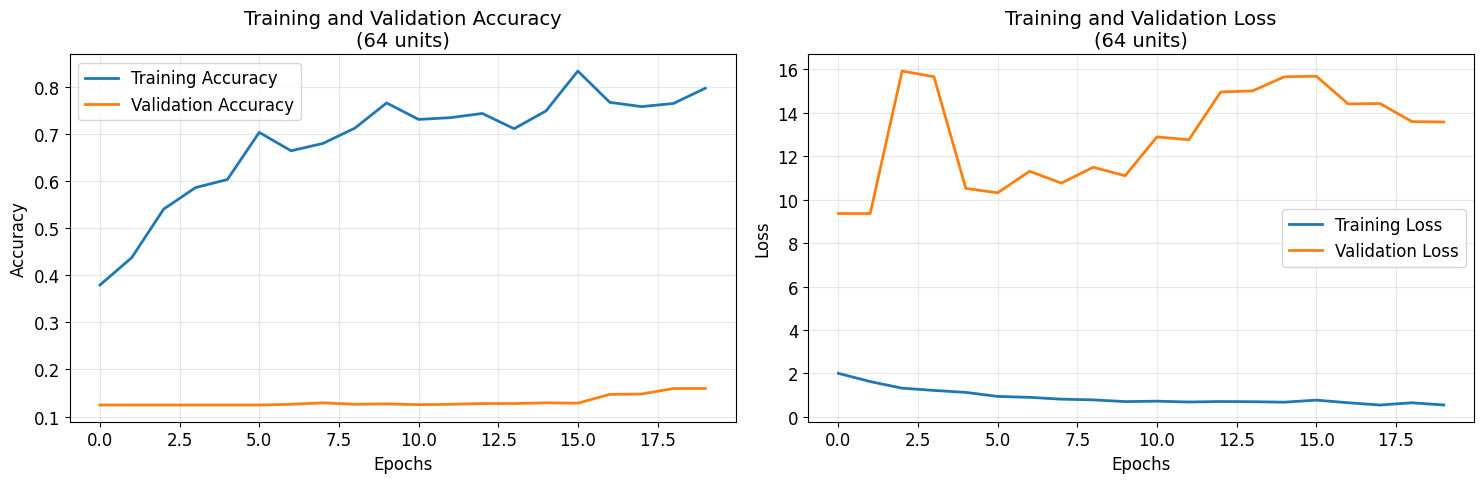

📊 Resultados para 64 unidades:
   Melhor acurácia treino: 0.8333
   Melhor acurácia validação: 0.1597

🧪 Testando com 128 unidades ocultas...

📋 Summary do modelo (128 unidades):


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,072,680 (65.13 MB)

 Trainable params: 17,070,760 (65.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 346s 11s/step - accuracy: 0.3609 - loss: 2.0448 - val_accuracy: 0.1262 - val_loss: 8.7567 - learning_rate: 0.0010
Epoch 2/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 663ms/step - accuracy: 0.4922 - loss: 1.3852 - val_accuracy: 0.1269 - val_loss: 8.6031 - learning_rate: 0.0010
Epoch 3/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 308s 10s/step - accuracy: 0.5540 - loss: 1.2819 - val_accuracy: 0.1246 - val_loss: 23.1004 - learning_rate: 0.0010
Epoch 4/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 664ms/step - accuracy: 0.5312 - loss: 1.5534 - val_accuracy: 0.1246 - val_loss: 25.3754 - learning_rate: 0.0010
Epoch 5/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 313s 10s/step - accuracy: 0.5771 - loss: 1.1939 - val_accuracy: 0.1425 - val_loss: 19.2856 - learning_rate: 0.0010
Epoch 6/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 687ms/step - accuracy: 0.7266 - loss: 0.8545 - val_accuracy: 0.1410 - val_loss: 19.4925 - learning_rate: 2.5000e-04
Epoch 7/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 310s 10s/step - accuracy: 0.6517

30/30 ━━━━━━━━━━━━━━━━━━━━ 226s 8s/step - accuracy: 0.7527 - loss: 0.6903 - val_accuracy: 0.1752 - val_loss: 5.4251 - learning_rate: 1.5625e-05
Epoch 20/300
 1/30 ━━━━━━━━━━━━━━━━━━━━ 3:25 7s/step - accuracy: 0.7734 - loss: 0.6318

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 514ms/step - accuracy: 0.7734 - loss: 0.6318 - val_accuracy: 0.1776 - val_loss: 5.3766 - learning_rate: 1.5625e-05
Epoch 21/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7424 - loss: 0.6951

30/30 ━━━━━━━━━━━━━━━━━━━━ 222s 7s/step - accuracy: 0.7530 - loss: 0.6725 - val_accuracy: 0.2290 - val_loss: 4.7357 - learning_rate: 1.5625e-05
Epoch 22/300
 1/30 ━━━━━━━━━━━━━━━━━━━━ 3:24 7s/step - accuracy: 0.7344 - loss: 0.6888

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 512ms/step - accuracy: 0.7344 - loss: 0.6888 - val_accuracy: 0.2321 - val_loss: 4.7405 - learning_rate: 1.5625e-05
Epoch 23/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7563 - loss: 0.6841

30/30 ━━━━━━━━━━━━━━━━━━━━ 220s 7s/step - accuracy: 0.7519 - loss: 0.6881 - val_accuracy: 0.2477 - val_loss: 4.7271 - learning_rate: 1.5625e-05
Epoch 24/300
 1/30 ━━━━━━━━━━━━━━━━━━━━ 3:26 7s/step - accuracy: 0.7969 - loss: 0.5493

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 526ms/step - accuracy: 0.7969 - loss: 0.5493 - val_accuracy: 0.2516 - val_loss: 4.6998 - learning_rate: 1.5625e-05
Epoch 25/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7557 - loss: 0.6756

30/30 ━━━━━━━━━━━━━━━━━━━━ 226s 8s/step - accuracy: 0.7511 - loss: 0.6782 - val_accuracy: 0.2726 - val_loss: 4.6207 - learning_rate: 1.5625e-05
Epoch 26/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 487ms/step - accuracy: 0.8047 - loss: 0.5579 - val_accuracy: 0.2718 - val_loss: 4.6063 - learning_rate: 1.5625e-05
Epoch 27/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7536 - loss: 0.6627

30/30 ━━━━━━━━━━━━━━━━━━━━ 223s 7s/step - accuracy: 0.7476 - loss: 0.6789 - val_accuracy: 0.2960 - val_loss: 4.6603 - learning_rate: 1.5625e-05
Epoch 28/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 485ms/step - accuracy: 0.7656 - loss: 0.6305 - val_accuracy: 0.2944 - val_loss: 4.6982 - learning_rate: 1.5625e-05
Epoch 29/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7581 - loss: 0.6552

30/30 ━━━━━━━━━━━━━━━━━━━━ 222s 7s/step - accuracy: 0.7511 - loss: 0.6699 - val_accuracy: 0.3684 - val_loss: 4.3061 - learning_rate: 1.5625e-05
Epoch 30/300
 1/30 ━━━━━━━━━━━━━━━━━━━━ 3:27 7s/step - accuracy: 0.7734 - loss: 0.6410

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 515ms/step - accuracy: 0.7734 - loss: 0.6410 - val_accuracy: 0.3699 - val_loss: 4.3045 - learning_rate: 1.5625e-05
Epoch 31/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7534 - loss: 0.6668

30/30 ━━━━━━━━━━━━━━━━━━━━ 220s 7s/step - accuracy: 0.7618 - loss: 0.6521 - val_accuracy: 0.3972 - val_loss: 4.1690 - learning_rate: 1.5625e-05
Epoch 32/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 495ms/step - accuracy: 0.6953 - loss: 0.6838 - val_accuracy: 0.3964 - val_loss: 4.1424 - learning_rate: 1.5625e-05
Epoch 33/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7639 - loss: 0.6397

30/30 ━━━━━━━━━━━━━━━━━━━━ 228s 8s/step - accuracy: 0.7621 - loss: 0.6449 - val_accuracy: 0.4042 - val_loss: 3.8172 - learning_rate: 1.5625e-05
Epoch 34/300
 1/30 ━━━━━━━━━━━━━━━━━━━━ 3:37 7s/step - accuracy: 0.7422 - loss: 0.7022

30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 535ms/step - accuracy: 0.7422 - loss: 0.7022 - val_accuracy: 0.4058 - val_loss: 3.8032 - learning_rate: 1.5625e-05
Epoch 35/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 225s 7s/step - accuracy: 0.7626 - loss: 0.6402 - val_accuracy: 0.4019 - val_loss: 3.5613 - learning_rate: 1.5625e-05
Epoch 36/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 521ms/step - accuracy: 0.8125 - loss: 0.5566 - val_accuracy: 0.4011 - val_loss: 3.5587 - learning_rate: 1.5625e-05
Epoch 37/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 257s 9s/step - accuracy: 0.7656 - loss: 0.6473 - val_accuracy: 0.4050 - val_loss: 3.1294 - learning_rate: 1.5625e-05
Epoch 38/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 615ms/step - accuracy: 0.7812 - loss: 0.6552 - val_accuracy: 0.4050 - val_loss: 3.1200 - learning_rate: 1.5625e-05
Epoch 39/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7513 - loss: 0.6491

30/30 ━━━━━━━━━━━━━━━━━━━━ 271s 9s/step - accuracy: 0.7481 - loss: 0.6636 - val_accuracy: 0.4221 - val_loss: 2.4213 - learning_rate: 1.5625e-05
Epoch 40/300
 1/30 ━━━━━━━━━━━━━━━━━━━━ 4:07 9s/step - accuracy: 0.7578 - loss: 0.6629

30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 740ms/step - accuracy: 0.7578 - loss: 0.6629 - val_accuracy: 0.4237 - val_loss: 2.3897 - learning_rate: 1.5625e-05
Epoch 41/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7672 - loss: 0.6325

30/30 ━━━━━━━━━━━━━━━━━━━━ 220s 7s/step - accuracy: 0.7640 - loss: 0.6370 - val_accuracy: 0.4564 - val_loss: 1.9318 - learning_rate: 1.5625e-05
Epoch 42/300
 1/30 ━━━━━━━━━━━━━━━━━━━━ 3:20 7s/step - accuracy: 0.8047 - loss: 0.5238

30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 560ms/step - accuracy: 0.8047 - loss: 0.5238 - val_accuracy: 0.4595 - val_loss: 1.9062 - learning_rate: 1.5625e-05
Epoch 43/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7631 - loss: 0.6439

30/30 ━━━━━━━━━━━━━━━━━━━━ 226s 8s/step - accuracy: 0.7648 - loss: 0.6364 - val_accuracy: 0.5405 - val_loss: 1.4415 - learning_rate: 1.5625e-05
Epoch 44/300
 1/30 ━━━━━━━━━━━━━━━━━━━━ 3:22 7s/step - accuracy: 0.7344 - loss: 0.7203

30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 560ms/step - accuracy: 0.7344 - loss: 0.7203 - val_accuracy: 0.5452 - val_loss: 1.4295 - learning_rate: 1.5625e-05
Epoch 45/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7687 - loss: 0.6419

30/30 ━━━━━━━━━━━━━━━━━━━━ 244s 8s/step - accuracy: 0.7739 - loss: 0.6136 - val_accuracy: 0.5958 - val_loss: 1.1852 - learning_rate: 1.5625e-05
Epoch 46/300
 1/30 ━━━━━━━━━━━━━━━━━━━━ 4:40 10s/step - accuracy: 0.7891 - loss: 0.6782

30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 597ms/step - accuracy: 0.7891 - loss: 0.6782 - val_accuracy: 0.6059 - val_loss: 1.1656 - learning_rate: 1.5625e-05
Epoch 47/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 249s 8s/step - accuracy: 0.7693 - loss: 0.6245 - val_accuracy: 0.5818 - val_loss: 1.2493 - learning_rate: 1.5625e-05
Epoch 48/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 547ms/step - accuracy: 0.7578 - loss: 0.6340 - val_accuracy: 0.5857 - val_loss: 1.2335 - learning_rate: 1.5625e-05
Epoch 49/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7705 - loss: 0.6063

30/30 ━━━━━━━━━━━━━━━━━━━━ 248s 8s/step - accuracy: 0.7744 - loss: 0.6021 - val_accuracy: 0.7336 - val_loss: 0.7544 - learning_rate: 1.5625e-05
Epoch 50/300
 1/30 ━━━━━━━━━━━━━━━━━━━━ 4:06 8s/step - accuracy: 0.7422 - loss: 0.6418

30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 537ms/step - accuracy: 0.7422 - loss: 0.6418 - val_accuracy: 0.7422 - val_loss: 0.7402 - learning_rate: 1.5625e-05
Epoch 51/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 221s 7s/step - accuracy: 0.7798 - loss: 0.5965 - val_accuracy: 0.7290 - val_loss: 0.7657 - learning_rate: 1.5625e-05
Epoch 52/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 711ms/step - accuracy: 0.7031 - loss: 0.7668 - val_accuracy: 0.7360 - val_loss: 0.7537 - learning_rate: 1.5625e-05
Epoch 53/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7850 - loss: 0.5692

30/30 ━━━━━━━━━━━━━━━━━━━━ 252s 8s/step - accuracy: 0.7897 - loss: 0.5757 - val_accuracy: 0.7936 - val_loss: 0.5739 - learning_rate: 1.5625e-05
Epoch 54/300
 1/30 ━━━━━━━━━━━━━━━━━━━━ 6:13 13s/step - accuracy: 0.7188 - loss: 0.7564

30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 589ms/step - accuracy: 0.7188 - loss: 0.7564 - val_accuracy: 0.7960 - val_loss: 0.5716 - learning_rate: 1.5625e-05
Epoch 55/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 236s 8s/step - accuracy: 0.7846 - loss: 0.5954 - val_accuracy: 0.7734 - val_loss: 0.6381 - learning_rate: 1.5625e-05
Epoch 56/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 711ms/step - accuracy: 0.7812 - loss: 0.5344 - val_accuracy: 0.7734 - val_loss: 0.6355 - learning_rate: 1.5625e-05
Epoch 57/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 225s 8s/step - accuracy: 0.7863 - loss: 0.5981 - val_accuracy: 0.7905 - val_loss: 0.5855 - learning_rate: 1.5625e-05
Epoch 58/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 475ms/step - accuracy: 0.7578 - loss: 0.6565 - val_accuracy: 0.7897 - val_loss: 0.5878 - learning_rate: 1.5625e-05
Epoch 59/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 216s 7s/step - accuracy: 0.7836 - loss: 0.5951 - val_accuracy: 0.7749 - val_loss: 0.6109 - learning_rate: 1.5625e-05
Epoch 60/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 485ms/step - accuracy

30/30 ━━━━━━━━━━━━━━━━━━━━ 228s 8s/step - accuracy: 0.7911 - loss: 0.5661 - val_accuracy: 0.7967 - val_loss: 0.5662 - learning_rate: 1.0000e-06
Epoch 68/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 485ms/step - accuracy: 0.7891 - loss: 0.5576 - val_accuracy: 0.7967 - val_loss: 0.5660 - learning_rate: 1.0000e-06
Epoch 69/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 221s 7s/step - accuracy: 0.7903 - loss: 0.5640 - val_accuracy: 0.7960 - val_loss: 0.5655 - learning_rate: 1.0000e-06
Epoch 70/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.7656 - loss: 0.6694 - val_accuracy: 0.7960 - val_loss: 0.5656 - learning_rate: 1.0000e-06
Epoch 71/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 222s 7s/step - accuracy: 0.7814 - loss: 0.5894 - val_accuracy: 0.7928 - val_loss: 0.5655 - learning_rate: 1.0000e-06
Epoch 72/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 502ms/step - accuracy: 0.8594 - loss: 0.3948 - val_accuracy: 0.7928 - val_loss: 0.5653 - learning_rate: 1.0000e-06
Epoch 73/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 224s 7s/step - accuracy: 

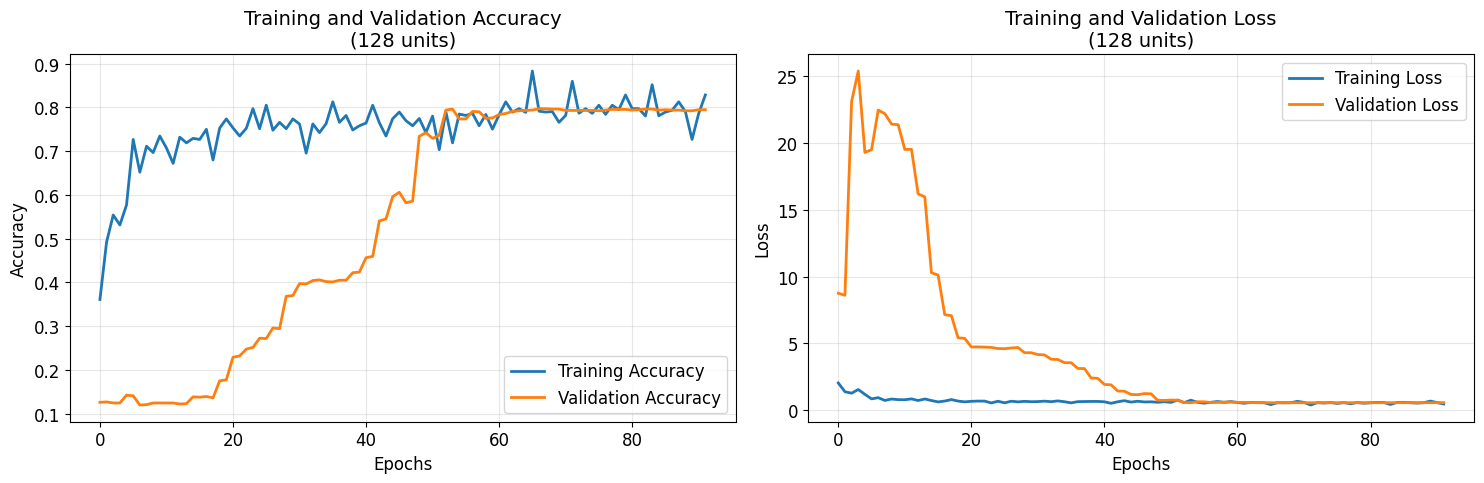

📊 Resultados para 128 unidades:
   Melhor acurácia treino: 0.8828
   Melhor acurácia validação: 0.7967

🧪 Testando com 256 unidades ocultas...

📋 Summary do modelo (256 unidades):


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,072,680 (65.13 MB)

 Trainable params: 17,070,760 (65.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 274s 8s/step - accuracy: 0.4052 - loss: 1.8895 - val_accuracy: 0.1246 - val_loss: 9.5497 - learning_rate: 0.0010
Epoch 2/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 523ms/step - accuracy: 0.5833 - loss: 1.3278 - val_accuracy: 0.1246 - val_loss: 10.0475 - learning_rate: 0.0010
Epoch 3/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 239s 8s/step - accuracy: 0.5158 - loss: 1.4343 - val_accuracy: 0.1246 - val_loss: 8.4997 - learning_rate: 0.0010
Epoch 4/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 498ms/step - accuracy: 0.5469 - loss: 1.2020 - val_accuracy: 0.1246 - val_loss: 7.9922 - learning_rate: 0.0010
Epoch 5/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 237s 8s/step - accuracy: 0.6380 - loss: 1.0067 - val_accuracy: 0.1379 - val_loss: 17.2598 - learning_rate: 0.0010
Epoch 6/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 504ms/step - accuracy: 0.6953 - loss: 0.7985 - val_accuracy: 0.1355 - val_loss: 17.4248 - learning_rate: 2.5000e-04
Epoch 7/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 228s 8s/step - accuracy: 0.7164 - lo

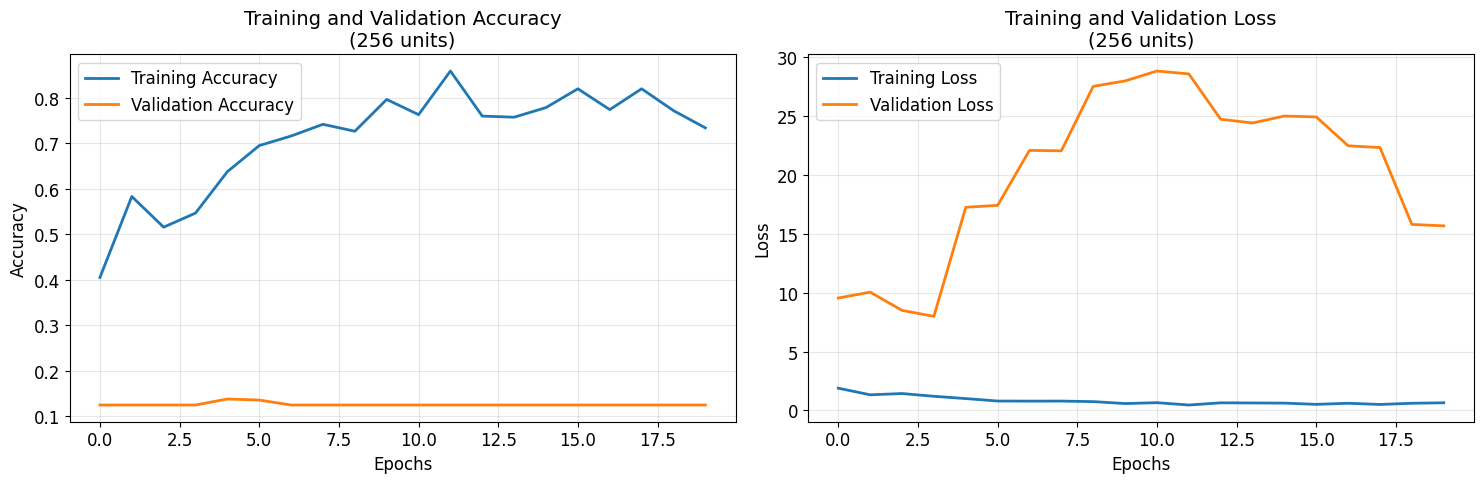

📊 Resultados para 256 unidades:
   Melhor acurácia treino: 0.8594
   Melhor acurácia validação: 0.1379

📈 COMPARAÇÃO FINAL DAS ARQUITETURAS:
   32 unidades: 0.1526 acurácia
   64 unidades: 0.1597 acurácia
   128 unidades: 0.7967 acurácia
   256 unidades: 0.1379 acurácia

🏆 MELHOR ARQUITETURA: 128 unidades ocultas
🎯 Melhor acurácia de validação: 0.7967

🎓 Treinando modelo final...
Epoch 1/600
30/30 ━━━━━━━━━━━━━━━━━━━━ 264s 8s/step - accuracy: 0.3915 - loss: 1.9360 - val_accuracy: 0.1246 - val_loss: 8.8319 - learning_rate: 0.0010
Epoch 2/600
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 511ms/step - accuracy: 0.4922 - loss: 1.4187 - val_accuracy: 0.1246 - val_loss: 9.1352 - learning_rate: 0.0010
Epoch 3/600
30/30 ━━━━━━━━━━━━━━━━━━━━ 236s 8s/step - accuracy: 0.5422 - loss: 1.2645 - val_accuracy: 0.1246 - val_loss: 17.4493 - learning_rate: 0.0010
Epoch 4/600
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 526ms/step - accuracy: 0.5469 - loss: 1.1423 - val_accuracy: 0.1246 - val_loss: 17.1570 - learning_rate: 0.0010
Epo

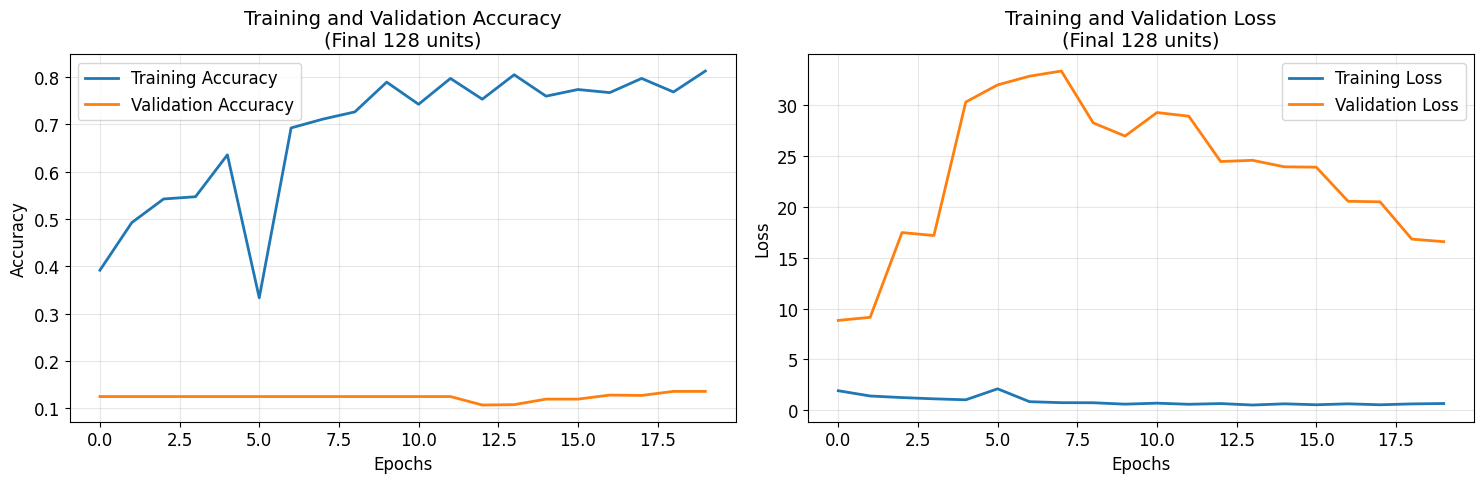


✅ ACURÁCIA FINAL NO TESTE: 0.1246
❌ RESULTADO RUIM: Acurácia abaixo de 50%
   Possíveis causas:
   - Poucas imagens por classe
   - MLP não é adequado para imagens
   - Tente usar CNN em vez de MLP

📋 SUMMARY DO MODELO FINAL:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,214,202 (195.37 MB)

 Trainable params: 17,070,760 (65.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 34,141,522 (130.24 MB)

In [6]:
# ================== USO PRÁTICO ==================
def main():
    # 1. Carregar imagens da pasta
    dataset_folder = "pasta de teste"
    
    print("Carregando imagens...")
    X, y, class_names = load_images_from_folder(dataset_folder)
    
    # Executar diagnóstico
    if not diagnosticar_dados(X, y, class_names):
        print("❌ Problemas encontrados nos dados. Corrija antes de continuar.")
        return
    
    print(f"\nCarregadas {len(X)} imagens de {len(class_names)} classes")

     # 2. Dividir dados em TREINO, VALIDAÇÃO e TESTE
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    print(f"📊 Dados divididos:")
    print(f"   Treino: {len(X_train)} imagens")
    print(f"   Validação: {len(X_val)} imagens")
    print(f"   Teste: {len(X_test)} imagens")

    # Criar data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Ajustar o data augmentation aos dados de treino
    datagen.fit(X_train)
    
    # Callbacks para melhor treinamento
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=5, min_lr=1e-6),
        ModelCheckpoint("melhor.h5", monitor='val_accuracy', save_best_only=True, mode="max")
    ]
    
    # 3. Encontrar melhor arquitetura
    best_accuracy = 0
    best_units = 0
    all_val_accuracies = []
    all_units = [32, 64, 128, 256]
    
    for hidden_units in all_units:
        print(f"\n" + "="*50)
        print(f"🧪 Testando com {hidden_units} unidades ocultas...")
        
        model = create_img_cnn(X_train[0].shape, len(class_names), hidden_units)
        
        # Mostrar summary do modelo
        print(f"\n📋 Summary do modelo ({hidden_units} unidades):")
        model.summary()
        
        # Treinar
        history = model.fit(
                          datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                          epochs=EPOCHS,
                        #   batch_size=BATCH_SIZE,
                        #   validation_split=0.2,
                          validation_data=(X_val, y_val),
                          steps_per_epoch=len(X_train) // BATCH_SIZE,
                          callbacks=callbacks,
                          verbose=1)
        
        # Plotar gráfico
        plot_training_history(history, hidden_units)
        
        # Avaliar
        val_accuracy = max(history.history['val_accuracy'])
        train_accuracy = max(history.history['accuracy'])
        all_val_accuracies.append(val_accuracy)
        
        print(f"📊 Resultados para {hidden_units} unidades:")
        print(f"   Melhor acurácia treino: {train_accuracy:.4f}")
        print(f"   Melhor acurácia validação: {val_accuracy:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_units = hidden_units
            
    # Plotar comparação entre arquiteturas
    print(f"\n📈 COMPARAÇÃO FINAL DAS ARQUITETURAS:")
    for units, acc in zip(all_units, all_val_accuracies):
        print(f"   {units} unidades: {acc:.4f} acurácia")
    
    # 4. Treinar modelo final
    print(f"\n" + "="*50)
    print(f"🏆 MELHOR ARQUITETURA: {best_units} unidades ocultas")
    print(f"🎯 Melhor acurácia de validação: {best_accuracy:.4f}")
    
    final_model = create_img_cnn(X_train[0].shape, len(class_names), best_units)
    
    # Treinar por mais tempo
    print("\n🎓 Treinando modelo final...")
    history_final = final_model.fit(
                   datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                   epochs=EPOCHS*2,
                #    batch_size=BATCH_SIZE,
                   validation_data=(X_val, y_val),
                   steps_per_epoch=len(X_train) // BATCH_SIZE,
                   callbacks=callbacks,
                   verbose=1)
    
    # Plotar resultados finais
    plot_training_history(history_final, f"Final {best_units}")

    # 5. Avaliar no teste
    test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ ACURÁCIA FINAL NO TESTE: {test_acc:.4f}")
    
    if test_acc < 0.5:
        print("❌ RESULTADO RUIM: Acurácia abaixo de 50%")
        print("   Possíveis causas:")
        print("   - Poucas imagens por classe")
        print("   - MLP não é adequado para imagens")
        print("   - Tente usar CNN em vez de MLP")
    elif test_acc < 0.7:
        print("⚠️  Resultado regular: Acurácia entre 50-70%")
    elif test_acc < 0.9:
        print("✅ Resultado bom: Acurácia entre 70-90%")
    else:
        print("🎉 Excelente resultado: Acurácia acima de 90%!")

    # 6. Mostrar summary final
    print(f"\n📋 SUMMARY DO MODELO FINAL:")
    final_model.summary()

if __name__ == "__main__":
    # Configurações de visualização
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (10, 6)
    plt.rcParams['font.size'] = 12
    
    main()